In [1]:
from qiskit import *
from qiskit.circuit import *
from qiskit import Aer
from qiskit.opflow import PauliTrotterEvolution, StateFn, PauliExpectation
from qiskit.opflow import CircuitSampler, PauliOp
from qiskit.opflow import I, X, Y, Z, Zero, One, Plus, Minus
from qiskit.circuit import Parameter
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.quantum_info import *

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.mappers import BravyiKitaevMapper
from qiskit_nature.circuit.library.initial_states import HartreeFock
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

from qiskit import BasicAer
from qiskit.algorithms import HamiltonianPhaseEstimation
from qiskit.opflow import I, X, Y, Z, StateFn, PauliTrotterEvolution, Suzuki


import numpy as np
from numpy import pi, sqrt, array
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from qiskit.quantum_info.operators.random import random_hermitian
import numpy as np

In [3]:
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

In [4]:
#FermionicOperator
fermionic_op= es_problem.hamiltonian.second_q_op()
print(fermionic_op)

Fermionic Operator
number spin orbitals=4, number terms=36
  0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.09046559989211565 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211556 * ( +_0 +_1 -_0 -_1 )
+ 0.33229086512764827 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.09046559989211565 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211556 * ( +_0 +_3 -_2 -_1 )
+ 0.33229086512764827 * ( +_0 +_3 -_3 -_0 )
+ 0.33229086512764816 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211574 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211564 * ( +_1 +_1 -_0 -_0 )
+ 0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ 0.33229086512764816 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211574 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211564 * ( +_1 +_3 -_2 -_0 )
+ 0.34928686136600906 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.09046559989211565 * ( +_2 +_0 -_1 -_3 )
+ 0.09046559989211556 * ( +_2 +_1 -_0 -_3 )
+ 0.33229086512764827 * ( +_2 +_1 -_1 -_2 )
+ 0.33785507740175813 * ( +_2 +_2 -_2 -_2 )
+ 0.0904655998921

In [6]:
converter = QubitConverter(JordanWignerMapper(), two_qubit_reduction=True,z2symmetry_reduction="auto")

qubit_op_reduction = converter.convert(fermionic_op,  num_particles=es_problem.num_particles,
                                       sector_locator=es_problem.symmetry_sector_locator)
print(qubit_op_reduction)

-1.0410931415166251 * I
- 0.7958748496863578 * Z
+ 0.1809311997842312 * X


In [7]:
op_matrix= qubit_op_reduction.to_matrix()
print(op_matrix)

[[-1.83696799+0.j  0.1809312 +0.j]
 [ 0.1809312 +0.j -0.24521829+0.j]]


In [104]:
from scipy.sparse import linalg

# Compute ground energy
eigs, _ = linalg.eigsh(op_matrix, k=1, which="SA")
ground_energy = eigs[0]

print("Ground_energy: {}".format(ground_energy))

Ground_energy: -1.8572750302023788


/opt/conda/lib/python3.8/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1265: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


In [105]:
from scipy.sparse import linalg
# Compute ground energy
eigs, _ = linalg.eigsh(op_matrix)
ground_energy = eigs[0]

print("Ground_energy: {}".format(ground_energy))

Ground_energy: -1.8572750302023788


In [8]:
# obtain basis transformation matrix (aka "u").

eigenvalues, eigenvectors = np.linalg.eigh(op_matrix)
basis_transformation_matrix = eigenvectors.transpose()
transformation_basis= np.real(basis_transformation_matrix)
print(transformation_basis)

[[-0.9937604   0.11153594]
 [-0.11153594 -0.9937604 ]]


In [34]:
# Initialize the qubit register.
register = QuantumRegister(2)
circuit = QuantumCircuit(register)

In [35]:
from qiskit_nature.second_q.circuit.library import BogoliubovTransform

# Start circuit with the inverse basis rotation, print out this step.
bog_circuit = BogoliubovTransform(transformation_basis)
circuit.append(bog_circuit.inverse(), register)

In [36]:
# Add diagonal phase rotations to circuit.

simulation_time=1
for k, eigenvalue in enumerate(eigenvalues):
    phase = -eigenvalue * simulation_time
    circuit.rz(phase, k)
    
# Finally, restore basis.
circuit.append(bog_circuit, register)


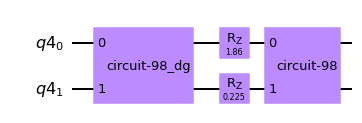

In [61]:
circuit.draw()

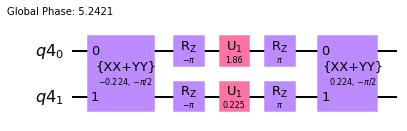

In [63]:
circuit.decompose().draw()

In [43]:
circuit_state = Statevector(circuit)
print(circuit_state )

Statevector([0.50527723-0.86295708j, 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ],
            dims=(2, 2))


In [55]:
from qiskit.quantum_info import random_statevector, Statevector
from qiskit import QuantumCircuit

# Initialize a random initial state.
initial_state= random_statevector(2)

In [67]:
# Numerically compute the correct circuit output.
exact_state = scipy.sparse.linalg.expm_multiply(-1j * simulation_time * op_matrix,np.array(initial_state))

In [75]:
print(exact_state)

[ 0.98591381-0.0900837j  -0.09961256+0.09968064j]


In [70]:
from qiskit import Aer

# get the simulated_state
simulator = Aer.get_backend('statevector_simulator')
result = execute(circuit, simulator,initial_layout=initial_state).result()
simulated_state = result.get_statevector()
print(simulated_state)

Statevector([ 5.05277225e-01-8.62957082e-01j,
              1.11022302e-16-5.55111512e-17j,
              9.81307787e-18+4.90653893e-18j,
             -7.70371978e-34+4.90653893e-18j],
            dims=(2, 2))


In [94]:
simulated_state_re= simulated_state.reshape((2, 2))
print(simulated_state_re)

[[ 5.05277225e-01-8.62957082e-01j  1.11022302e-16-5.55111512e-17j]
 [ 9.81307787e-18+4.90653893e-18j -7.70371978e-34+4.90653893e-18j]]


/tmp/ipykernel_12693/1541667450.py:1: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  simulated_state_re= simulated_state.reshape((2, 2))


In [95]:
import numpy as np

# Print final fidelity.
fidelity = abs(np.dot(simulated_state_re, np.conjugate(exact_state)))**2
print(fidelity)

[9.80141109e-01 1.21896888e-34]
